# MovieLens 1M dataset

```bash
wget https://files.grouplens.org/datasets/movielens/ml-1m.zip <YOUR-LOCAL-PATH>/.
```

In [1]:
import re
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_path = "/Users/deepak.dhull/practice/recsys/data/ml-1m"
os.listdir(base_path)

['movies.dat', 'ratings.dat', 'README', 'users.dat', 'stats.json']

### Reading files: convert it into pd.Dataframe

In [3]:
rating_cols = "UserID::MovieID::Rating::Timestamp".split("::")
user_cols = "UserID::Gender::Age::Occupation::ZipCode".split("::")
movie_cols = "MovieID::Title::Genres".split("::")

#### column types #####

rating_types = {
    'UserID': 'int32',
    'MovieID': 'int32',
    'Rating': 'int32',
    'Timestamp': 'int32'
}

user_types = {
    'UserID': 'int32',
    'Gender': 'string',
    'Age': 'int32',
    'Occupation': 'int32',
    'ZipCode': 'string'
}

movie_types = {
    'MovieID': 'int32',
    'Title': 'string',
    'Genres': 'string'
}


In [4]:
def dat_to_df(path, cols, col_dtypes, format='r'):
    with open(path, format) as f:
        content = f.readlines()

    def fn(data):
        if format == 'rb':
            data = data.decode('latin-1').encode('utf-8').decode('utf-8')
        data = data.replace("\n", "")
        return data.split("::")

    content = list(map(lambda x: fn(x), content))
    df = pd.DataFrame(content, columns=cols)
    for col in cols:
        df[col] = df[col].astype(col_dtypes[col])
    return df

In [5]:
rating_df = dat_to_df(f"{base_path}/ratings.dat", rating_cols, rating_types)
user_df = dat_to_df(f"{base_path}/users.dat", user_cols, user_types)
movie_df = dat_to_df(f"{base_path}/movies.dat", movie_cols, movie_types, format='rb')

rating_df.shape, user_df.shape, movie_df.shape

((1000209, 4), (6040, 5), (3883, 3))

In [6]:
rating_df.head(3)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [7]:
user_df.head(3)

,UserID,Gender,Age,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


In [8]:
movie_df.head(3)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


### Feature engineering

#### Content Feature engineering

In [9]:
def get_year(s):
    _s = re.findall(r'\d{4}', s)
    return int(_s[-1])

movie_df['releaseYear'] = movie_df['Title'].map(get_year)

In [10]:
movie_year_count = movie_df['releaseYear'].value_counts()
movie_year_count = sorted([(i,y)for i, y in movie_year_count.items()], key=lambda x: int(x[0]))
x = [i[0] for i in movie_year_count]
y = [i[1] for i in movie_year_count]

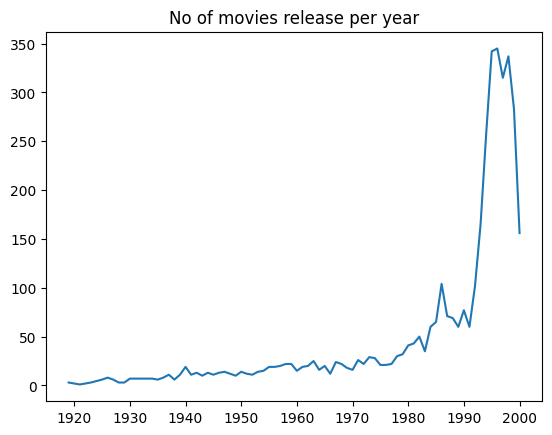

In [11]:
plt.title("No of movies release per year")
plt.plot(x,y)
plt.show()

In [12]:
def func_genre_split(x):
    x = x.split("|")
    return [i.split("'")[0] for i in x]

movie_df['Genres_list'] = movie_df['Genres'].map(func_genre_split)

In [13]:
movie_df['Genres_list'][0]

['Animation', 'Children', 'Comedy']

In [14]:
genres = set()
for m in movie_df['Genres_list'].tolist():
    genres = genres.union(m)
print("number of genres: ", len(genres))
print(list(genres))

number of genres:  18
['Crime', 'Western', 'Thriller', 'War', 'Horror', 'Drama', 'Action', 'Film-Noir', 'Animation', 'Documentary', 'Adventure', 'Comedy', 'Fantasy', 'Musical', 'Children', 'Sci-Fi', 'Romance', 'Mystery']


In [15]:
movie_df

,MovieID,Title,Genres,releaseYear,Genres_list
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,"[Animation, Children, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),Comedy,1995,[Comedy]
...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000,[Comedy]
3879,3949,Requiem for a Dream (2000),Drama,2000,[Drama]
3880,3950,Tigerland (2000),Drama,2000,[Drama]
3881,3951,Two Family House (2000),Drama,2000,[Drama]


In [16]:
movie_df['Genres_list'].map(len).value_counts()

Genres_list
1    2025
2    1322
3     421
4     100
5      14
6       1
Name: count, dtype: int64

In [17]:
def h(s):
    s = s.split("(")[0].strip()
    return s

movie_df['Title'] = movie_df['Title'].map(h)

##### Title embedding generation

In [18]:
glove_file_path = "/Users/deepak.dhull/practice/recsys/data/models/glove.6B.100d.txt"


embedding_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [19]:
import string

In [42]:
def get_movie_title_embedding(title, emb_size = 100):
    # Tokenize the movie title
    tokens = title.split()
    
    # Initialize an empty list to store word vectors
    word_vectors = []
    
    # Iterate over tokens and get word vectors
    for token in tokens:
        token = token.lower().strip()
        token = "".join([t for t in token if t not in string.punctuation])
        # Check if token exists in the vocabulary
        if token in embedding_index:
            word_vectors.append(embedding_index[token])
    
    # Calculate the average of word vectors
    if len(word_vectors):
        # Convert list of vectors to numpy array
        word_vectors = np.array(word_vectors)
        # Average the word vectors along axis 0 (rows)
        title_embedding = np.mean(word_vectors, axis=0)
        title_embedding = title_embedding/ np.linalg.norm(title_embedding)
        return title_embedding[:emb_size]
    else:
        return np.zeros(emb_size, dtype='float32')

In [43]:
movie_df['embedding'] = movie_df['Title'].map(lambda t: get_movie_title_embedding(t))

##### Preprocessing

In [22]:
for genre in genres:
    movie_df[genre] = movie_df['Genres_list'].map(lambda li: int(genre in li))

In [23]:
movie_df.head()

,MovieID,Title,Genres,releaseYear,Genres_list,embedding,Crime,Western,Thriller,War,...,Animation,Documentary,Adventure,Comedy,Fantasy,Musical,Children,Sci-Fi,Romance,Mystery
0,1,Toy Story,Animation|Children's|Comedy,1995,"[Animation, Children, Comedy]","[0.018508311, 0.15843399, 0.059110038, -0.0859...",0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,"[Adventure, Children, Fantasy]","[0.1332978, -0.026470864, 0.11734792, 0.001397...",0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995,"[Comedy, Romance]","[0.15969068, 0.12709527, 0.044178534, -0.06089...",0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4,Waiting to Exhale,Comedy|Drama,1995,"[Comedy, Drama]","[-0.0011229091, 0.052808262, 0.08829727, -0.01...",0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995,[Comedy],"[0.0043333857, 0.009456386, 0.07561622, 0.0147...",0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### User Feature engineering

In [24]:
user_df['Gender'].value_counts()

Gender
M    4331
F    1709
Name: count, dtype: Int64

In [25]:
gender_c = {v: i for i, v in enumerate(['M', 'F'])}

user_df['GenderValue'] = user_df['Gender'].map(lambda x: gender_c[x])

In [26]:
age2i = { v: i for i,v in enumerate(set(user_df['Age'].tolist()))}
i2age = { v:i for i,v in age2i.items()}

In [27]:
age2i, i2age

({1: 0, 35: 1, 45: 2, 50: 3, 18: 4, 56: 5, 25: 6},
 {0: 1, 1: 35, 2: 45, 3: 50, 4: 18, 5: 56, 6: 25})

In [28]:
user_df['AgeValue'] = user_df['Age'].map(lambda x: age2i[x])

In [29]:
user_df.head()

,UserID,Gender,Age,Occupation,ZipCode,GenderValue,AgeValue
0,1,F,1,10,48067,1,0
1,2,M,56,16,70072,0,5
2,3,M,25,15,55117,0,6
3,4,M,45,7,02460,0,2
4,5,M,25,20,55455,0,6


In [30]:
occupation2i = { v: i for i,v in enumerate(set(user_df['Occupation'].tolist()))}
i2occupation = { v:i for i,v in occupation2i.items()}

In [31]:
user_df['OccupationValue'] = user_df['Occupation'].map(lambda x: occupation2i[x])

In [32]:
stats = {
    "age": {
        'v2i': age2i,
        'i2v': i2age
    },
    "occupation": {
        'v2i': occupation2i,
        'i2v': i2occupation
    },
    "gender": {
        'v2i': gender_c
    }
}

In [33]:
import json

In [34]:
json.dump(stats, open("../../../data/ml-1m/stats.json", 'w'))

#### Join user and item table in action table

In [35]:
rating_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [46]:
join_df = pd.merge(rating_df, user_df, on="UserID", how='inner')

In [47]:
join_df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,ZipCode,GenderValue,AgeValue,OccupationValue
0,1,1193,5,978300760,F,1,10,48067,1,0,10
1,1,661,3,978302109,F,1,10,48067,1,0,10
2,1,914,3,978301968,F,1,10,48067,1,0,10
3,1,3408,4,978300275,F,1,10,48067,1,0,10
4,1,2355,5,978824291,F,1,10,48067,1,0,10


In [48]:
join_df = pd.merge(join_df, movie_df, on="MovieID", how='inner')

In [49]:
join_df.to_parquet("../../../data/ml-1m/data.pq", index=False)

In [50]:
join_df.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Gender', 'Age',
       'Occupation', 'ZipCode', 'GenderValue', 'AgeValue', 'OccupationValue',
       'Title', 'Genres', 'releaseYear', 'Genres_list', 'embedding', 'Crime',
       'Western', 'Thriller', 'War', 'Horror', 'Drama', 'Action', 'Film-Noir',
       'Animation', 'Documentary', 'Adventure', 'Comedy', 'Fantasy', 'Musical',
       'Children', 'Sci-Fi', 'Romance', 'Mystery'],
      dtype='object')